<a href="https://colab.research.google.com/github/nikpournastaran/Minerva-RAG-Grammar/blob/main/Minerva_RAG_Grammar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PHASE 1: THE VOICE ASSISTANT APP

1. INSTALL DEPENDENCIES

In [ ]:
!pip install -q gradio openai-whisper transformers accelerate bitsandbytes gtts langchain langchain-community langchain-core huggingface_hub

import gradio as gr
import whisper
import torch
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from langchain_community.llms import HuggingFacePipeline
from langchain_core.prompts import PromptTemplate
from gtts import gTTS
import os
import tempfile

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.2/803.2 kB 20.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 76.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.


2. CONFIGURATION

In [ ]:
LANG = "it"
WHISPER_MODEL_SIZE = "small"
LLM_MODEL_ID = "sapienzanlp/Minerva-7B-instruct-v1.0"
current_knowledge_base = "" # حافظه فایل‌های آپلود شده

DEFAULT_SYSTEM_PROMPT = """
You are an advanced Italian Grammar Assistant.
Your task is to analyze the user's spoken sentence based on the provided context (examples).
- If the input is a question with options (A/B), choose the correct one.
- If the input requires grammatical analysis (subject, verb, etc.), perform the analysis.
Keep the answer concise and strictly follow the format of the provided examples.
"""

3. LOAD MODELS

In [ ]:
print("⏳ Loading Whisper...")
whisper_model = whisper.load_model(WHISPER_MODEL_SIZE)

print("⏳ Loading Minerva LLM...")
quant_config = BitsAndBytesConfig(load_in_8bit=True, llm_int8_threshold=6.0)

try:
    tokenizer = AutoTokenizer.from_pretrained(LLM_MODEL_ID)
    model = AutoModelForCausalLM.from_pretrained(LLM_MODEL_ID, quantization_config=quant_config, device_map="auto")

    pipe = pipeline(
        "text-generation", model=model, tokenizer=tokenizer,
        max_new_tokens=256, temperature=0.3, top_p=0.9, do_sample=True,
        pad_token_id=tokenizer.eos_token_id
    )
    llm = HuggingFacePipeline(pipeline=pipe)
except Exception as e:
    print(f"Error: {e}")

⏳ Loading Whisper...


100%|████████████████████████████████████████| 461M/461M [00:02<00:00, 235MiB/s]


⏳ Loading Minerva LLM...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/670 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/761 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/226 [00:00<?, ?B/s]

Device set to use cuda:0
/tmp/ipython-input-3691150807.py:16: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the `langchain-huggingface package and should be used instead. To use it run `pip install -U `langchain-huggingface` and import as `from `langchain_huggingface import HuggingFacePipeline``.
  llm = HuggingFacePipeline(pipeline=pipe)


4. HELPER FUNCTIONS

In [ ]:
def update_context(files):
    global current_knowledge_base
    context_text = ""
    if not files: return "No files."
    for file in files:
        with open(file.name, "r", encoding="utf-8") as f:
            context_text += f"\n--- {os.path.basename(file.name)} ---\n{f.read()}\n"
    current_knowledge_base = context_text
    return "✅ Knowledge Base Updated!"

def text_to_speech(text):
    if not text: return None
    tts = gTTS(text=text, lang="it")
    with tempfile.NamedTemporaryFile(delete=False, suffix=".mp3") as fp:
        tts.save(fp.name)
        return fp.name

5. MAIN PIPELINE (RAG)

In [ ]:
def process_pipeline(audio_path):
    if audio_path is None: return "No audio.", None

    # A. Transcribe
    user_text = whisper_model.transcribe(audio_path, language="it")["text"]

    # B. Prepare Context (RAG)
    final_context = DEFAULT_SYSTEM_PROMPT
    if current_knowledge_base:
        final_context += f"\n\n### CONTEXT:\n{current_knowledge_base}"

    # C. Generate Answer
    prompt = f"Instructions:\n{final_context}\n\nUser:\n{user_text}\n\nAssistant (Italian):"
    full_response = llm.invoke(prompt)
    clean_response = full_response.replace(prompt, "").split("Assistant (Italian):")[-1].strip()

    # D. Speak
    audio_out = text_to_speech(clean_response)
    return f"🗣️ User: {user_text}\n🤖 AI: {clean_response}", audio_out

6. UI (GRADIO)

In [ ]:
with gr.Blocks(theme=gr.themes.Soft(), title="Italian AI Tutor") as demo:
    gr.Markdown("# 🇮🇹 AI Voice Assistant (Demo)")
    with gr.Row():
        with gr.Column():
            files = gr.File(label="Upload Grammar Rules (.txt)", file_count="multiple")
            btn_upd = gr.Button("Load Rules")
            status = gr.Textbox(label="Status")
            btn_upd.click(update_context, files, status)
        with gr.Column():
            mic = gr.Audio(sources=["microphone"], type="filepath")
            btn_run = gr.Button("Analyze")
            out_txt = gr.Markdown()
            out_aud = gr.Audio(autoplay=True)
            btn_run.click(process_pipeline, mic, [out_txt, out_aud])

demo.launch(share=True)

/tmp/ipython-input-53017004.py:1: DeprecationWarning: The 'theme' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'theme' to Blocks.launch() instead.
  with gr.Blocks(theme=gr.themes.Soft(), title="Italian AI Tutor") as demo:


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://b58819b5aab1498f24.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# PHASE 2: SCIENTIFIC EVALUATION (CSV Generation)

⚠️ IMPORTANT: Restart Runtime before running this!

In [ ]:
import json
import re
import csv
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline, BitsAndBytesConfig

  DATA SETUP

In [ ]:
!pip install -q openai-whisper transformers accelerate bitsandbytes gtts langchain langchain-community langchain-core huggingface_hub pandas
print("✅ Installation complete.")

✅ Installation complete.


1. RAW DATA INPUT (Based on your files)

In [ ]:
RAW_TEXT_1 = """
---------------------------------------------------------Domanda 1----------------------------------------------------------------------------------------------
Quale di queste due frasi è grammaticalmente corretta?
a. Il papà è entusiato.
b. Il papà è entusiasta.
"b. Il papà è entusiasta."
---------------------------------------------------------Domanda 2----------------------------------------------------------------------------------------------
Quale di queste due frasi è grammaticalmente corretta?
a. Marco e Lucia sono molto belle.
b. Marco e Lucia sono molto belli.
"b. Marco e Lucia sono molto belli."
---------------------------------------------------------Domanda 3----------------------------------------------------------------------------------------------
Quale di queste due frasi è grammaticalmente corretta?
a. Il cane e il bambino correvano insieme.
b. Il cane e il bambino correva insieme.
"a. Il cane e il bambino correvano insieme."
---------------------------------------------------------Domanda 4----------------------------------------------------------------------------------------------
Quale di queste due frasi è grammaticalmente corretta?
a. Non so se al suo posto avrei fatto lo stesso.
b. Non so se al suo posto avessi fatto lo stesso.
"b. Non so se al suo posto avrei fatto lo stesso."
---------------------------------------------------------Domanda 5----------------------------------------------------------------------------------------------
Quale di queste due frasi è grammaticalmente corretta?
a. Quelli sono i libri della quale ti ho parlato.
b. Quelli sono i libri di cui ti ho parlato.
"b. Quelli sono i libri di cui ti ho parlato."
---------------------------------------------------------Domanda 6----------------------------------------------------------------------------------------------
Quale di queste due frasi è grammaticalmente corretta?
a. Ho incontrato Anna e gli ho dato un passaggio a casa.
b. Ho incontrato Anna e le ho dato un passaggio a casa.
"b. Ho incontrato Anna e le ho dato un passaggio a casa."
---------------------------------------------------------Domanda 7----------------------------------------------------------------------------------------------
Quale di queste due frasi è grammaticalmente corretta?
a. Ieri sono andato al cinema con mia madre.
b. Ieri ho andato al cinema con mia madre.
"La frase corretta è ""Ieri sono andato al cinema con mia madre."
---------------------------------------------------------Domanda 8----------------------------------------------------------------------------------------------
Quale di queste due frasi è grammaticalmente corretta?
a.  Il film che ho visto ieri mi è piaciuto molto.
b.  Il film il quale ho visto ieri mi è piaciuto molto.
"La frase corretta è: a. Il film che ho visto ieri mi è piaciuto molto.""
---------------------------------------------------------Domanda 9----------------------------------------------------------------------------------------------
Quale di queste due frasi è grammaticalmente corretta?
a. Quando Lucia e Marco arrivano, inizieremo a mangiare.
b. Quando Lucia e Marco arriva, inizieremo a mangiare."
"b. Quando Lucia e Marco arriva, inizieremo a mangiare."
---------------------------------------------------------Domanda 10----------------------------------------------------------------------------------------------
Quale di queste due frasi è grammaticalmente corretta?
a. Ieri sono andata al ristorante di cui mi hai parlato.
b. Ieri sono andata al ristorante che mi hai parlato.
"La frase corretta è la prima, ""Ieri sono andata al ristorante di cui mi hai parlato"
---------------------------------------------------------Domanda 11----------------------------------------------------------------------------------------------
Quale di queste due frasi è grammaticalmente corretta?
a. Sabato scorso di siamo divertito molto alla festa di Luca.
b. Sabato scorso di siamo divertiti molto alla festa di Luca.
"b. Sabato scorso ci siamo divertiti molto alla festa di Luca."
---------------------------------------------------------Domanda 12----------------------------------------------------------------------------------------------
1"Quale di queste due frasi è grammaticalmente corretta?
a. Spento la sveglia, mi sono alzata dal letto.
b. Spenta la sveglia, mi sono alzata dal letto."
"b. Spenta la sveglia, mi sono alzata dal letto."
---------------------------------------------------------Domanda 13----------------------------------------------------------------------------------------------
13,Quale di queste due frasi è grammaticalmente corretta?
a. Il sole splendeva gialla nel cielo.
b. Il sole splendeva giallo nel cielo.
"La risposta corretta è b. Il sole splendeva giallo nel cielo."
---------------------------------------------------------Domanda 14----------------------------------------------------------------------------------------------
Quale di queste due frasi è grammaticalmente corretta?
a. Ad Antonella le piacciono i film d'azione.
b. Ad Antonella piacciono i film d'azione.
"b. Ad Antonella piacciono i film d'azione."
---------------------------------------------------------Domanda 15----------------------------------------------------------------------------------------------
Quale di queste due frasi è grammaticalmente corretta?
a. Filippo si ha fatto male giocando a calcetto.
b. Filippo si è fatto male giocando a calcetto.
"b. Filippo si è fatto male giocando a calcetto."
---------------------------------------------------------Domanda 16----------------------------------------------------------------------------------------------
Quale di queste due frasi è grammaticalmente corretta?
a. Se volevo andare via l'avrei già fatto.
b. Se avessi voluto andare via l'avrei già fatto.
"b. Se avessi voluto andare via l'avrei già fatto."
---------------------------------------------------------Domanda 17----------------------------------------------------------------------------------------------
Quale di queste due frasi è grammaticalmente corretta?
a. Matteo, dopo aver salutato Luca, sono andati via.
b. Matteo, dopo aver salutato Luca, è andato via."
"b. Matteo, dopo aver salutato Luca, è andato via."
---------------------------------------------------------Domanda 18----------------------------------------------------------------------------------------------
Quale di queste due frasi è grammaticalmente corretta?
a. Ho letto il libro che mi hai consigliato.
b. Ho letto il libro di cui mi hai consigliato.
La frase corretta è: ""Ho letto il libro che mi hai consigliato."
---------------------------------------------------------Domanda 19----------------------------------------------------------------------------------------------
Quale di queste due frasi è grammaticalmente corretta?
a. Nella valle si sentiva un eco fortissimo.
b. Nella valle si sentiva un'eco fortissima.
"La frase corretta è la prima, "Nella valle si sentiva un eco fortissimo"
---------------------------------------------------------Domanda 20----------------------------------------------------------------------------------------------
Quale di queste due frasi è grammaticalmente corretta?
a. Il bambino ha rotto i giocattoli.
b. Il bambino ha rotti i giocattoli.
"b. Il bambino ha rotti i giocattoli."
"""

RAW_TEXT_2 = """
---------------------------------------------------------Domanda 1----------------------------------------------------------------------------------------------
Individua il soggetto nella frase seguente: Mi piace il gelato al cioccolato.
"Il soggetto è ""Mi piace"".
---------------------------------------------------------Domanda 2----------------------------------------------------------------------------------------------
Individua il soggetto nella frase seguente: Il gatto ha mangiato il topo.
"Il gatto è il soggetto della frase."
---------------------------------------------------------Domanda 3----------------------------------------------------------------------------------------------
Individua il soggetto nella frase seguente: Ieri ha piovuto tutta la giornata.
"Il soggetto è ""Ieri"".
---------------------------------------------------------Domanda 4----------------------------------------------------------------------------------------------
Individua il soggetto nella frase seguente: Anna si è fatta male cadendo dall'altalena.
"Il soggetto è ""Anna"".
---------------------------------------------------------Domanda 5----------------------------------------------------------------------------------------------
Individua il soggetto nella frase seguente: Chi ti ha detto di aprire la porta?
"Il soggetto è ""tu"" perché si riferisce alla persona che viene interrogata sulla questione.""
---------------------------------------------------------Domanda 6----------------------------------------------------------------------------------------------
Individua il soggetto nella frase seguente: A dirmelo è stato Luca.
"Luca."
---------------------------------------------------------Domanda 7----------------------------------------------------------------------------------------------
Individua il soggetto nella frase seguente: Oggi si mangia a casa
"Il soggetto è ""Oggi"" perché è la persona o l'oggetto che compie l'azione della frase.""
---------------------------------------------------------Domanda 8----------------------------------------------------------------------------------------------
Individua il soggetto della frase Solitamente mi lavo i capelli tre volte a settimana
"Il soggetto è ""mi"" (io).
---------------------------------------------------------Domanda 9----------------------------------------------------------------------------------------------
Individua il soggetto della frase: Chissà cosa è successo dopo
Il soggetto è ""cosa"".
---------------------------------------------------------Domanda 10----------------------------------------------------------------------------------------------
Individua il soggetto nella frase seguente: Ieri mi è capitata una cosa strana
"Il soggetto della frase è ""io"" perché la frase indica che l'azione viene compiuta da un individuo specifico, ovvero colui che parla o scrive.""
---------------------------------------------------------Domanda 11----------------------------------------------------------------------------------------------
"Indica quale funziona ha il ""che"" nella frase seguente: Che mi racconti di nuovo?"
"Il che è una congiunzione subordinante, quindi la risposta corretta è che funziona come subordinata alla frase principale ""mi racconti""."
---------------------------------------------------------Domanda 12----------------------------------------------------------------------------------------------
"Indica quale funziona ha il ""che"" nella frase seguente: Ieri ho incontrato Luca che mi ha raccontato del suo viaggio a Parigi."
"Il ""che"" nella frase è un pronome relativo che introduce una proposizione subordinata relativa al soggetto ""Luca"".
---------------------------------------------------------Domanda 13----------------------------------------------------------------------------------------------
"Indica quale funziona ha il ""che"" nella frase seguente: Stasera non posso fare troppo tardi che domani mi devo svegliare presto."
"Il ""che"" introduce una proposizione relativa (che specifica un termine della frase precedente) e quindi ha funzione di congiunzione subordinante.
---------------------------------------------------------Domanda 14----------------------------------------------------------------------------------------------
"Indica quale funziona ha il ""che"" nella frase seguente: Se non fossi riuscita a prendere l'ultimo treno non avrei saputo che fare."
"Il ""che"" introduce una proposizione relativa, quindi è la risposta corretta."
---------------------------------------------------------Domanda 15----------------------------------------------------------------------------------------------
"Indica quale funziona ha il ""che"" nella frase seguente: Che hai combinato!"
"Il che è una congiunzione subordinante che introduce una proposizione subordinata relativa, indicando un'azione o una situazione che si verifica dopo l'avverbio di tempo ""hai"".
---------------------------------------------------------Domanda 16----------------------------------------------------------------------------------------------
"Indica quale funziona ha il ""che"" nella frase seguente: Mi dispiace che te vada così presto."
"Il ""che"" in questa frase è una congiunzione subordinante che introduce la proposizione relativa ""Mi dispiace che"". Quindi, il ""che"" funziona come subordinata alla proposizione principale ""Mi dispiace che te vada così presto"".
---------------------------------------------------------Domanda 17----------------------------------------------------------------------------------------------
"Indica quale funziona ha il ""che"" nella frase seguente: Hai visto che bel giardino!"
"Il ""che"" è un pronome relativo"
---------------------------------------------------------Domanda 18----------------------------------------------------------------------------------------------
"Indica quale funziona ha il ""che"" nella frase seguente: Che hai fatto sabato sera?"
"Il ""che"" è una congiunzione subordinante che introduce la proposizione dipendente ""hai fatto sabato sera"". Quindi, la risposta è: ""Che hai fatto sabato sera?""
---------------------------------------------------------Domanda 19----------------------------------------------------------------------------------------------
"Indica quale funziona ha il ""che"" nella frase seguente: I film d'azione sono quelli che preferisco."
"Il ""che"" introduce una proposizione relativa, quindi la risposta è ""I film d'azione sono quelli che preferisco"".
---------------------------------------------------------Domanda 20----------------------------------------------------------------------------------------------
1"Indica quale funziona ha il ""che"" nella frase seguente: Ieri ho conosciuto Anna. Che persona interessante!"
"Il ""che"" in questa frase è un pronome relativo che introduce una subordinata relativa, ovvero la frase ""persona interessante"". Quindi il ""che"" funziona come congiunzione subordinante."
---------------------------------------------------------Domanda 21----------------------------------------------------------------------------------------------
1"Indica quale funziona ha il ""che"" nella frase seguente: Che film hai visto quanto sei andato al cinema?"
"Il ""che"" è una congiunzione che introduce una proposizione subordinata, quindi la risposta è ""hai visto""."
---------------------------------------------------------Domanda 22----------------------------------------------------------------------------------------------
"Indica quale funziona ha il ""che"" nella frase seguente: Avevo così tanto sonno che mi sono addormentato sul divano."
"Il ""che"" è una congiunzione coordinante."
"""

2. DATA PARSING (Cleaning the text)

In [ ]:
def parse_dataset(text_data, q_type="type1"):
    questions = []
    chunks = re.split(r'-{10,}Domanda \d+-{10,}', text_data)
    for chunk in chunks:
        chunk = chunk.strip()
        if not chunk: continue
        lines = [l.strip() for l in chunk.split('\n') if l.strip()]

        if q_type == "type1": # Multiple Choice
            # Find the answer line (heuristic)
            answer_line = next((l for l in lines if l.startswith('"') or l.startswith("La frase") or l.startswith("b.") or l.startswith("a.")), lines[-1])
            question_text = "\n".join([l for l in lines if l != answer_line])
            ground_truth = answer_line.replace('"', '').strip()
        else: # Analysis
            question_text = lines[0]
            if len(lines) > 1:
                ground_truth = " ".join(lines[1:]).replace('"', '').strip()
            else:
                ground_truth = "N/A"

        questions.append({"question": question_text, "ground_truth": ground_truth})
    return questions

# Combine Datasets
dataset = parse_dataset(RAW_TEXT_1, "type1") + parse_dataset(RAW_TEXT_2, "type2")
print(f"✅ Extracted {len(dataset)} questions from raw files.")

✅ Extracted 42 questions from raw files.


3. MINERVA GENERATION

In [ ]:
MODEL_ID = "sapienzanlp/Minerva-7B-instruct-v1.0"
print("⏳ Loading Minerva Model (4-bit)...")

quant_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=torch.float16)

try:
    tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
    model = AutoModelForCausalLM.from_pretrained(MODEL_ID, quantization_config=quant_config, device_map="auto")

    pipe = pipeline(
        "text-generation", model=model, tokenizer=tokenizer,
        max_new_tokens=150, temperature=0.1, do_sample=False,
        pad_token_id=tokenizer.eos_token_id
    )

    final_data = []
    print("🚀 Generating answers...")

    for i, item in enumerate(dataset):
        prompt = f"Sei un esperto di grammatica italiana.\nDomanda: {item['question']}\nRisposta:"
        try:
            res = pipe(prompt)[0]['generated_text']
            minerva_ans = res.replace(prompt, "").split("Domanda:")[0].strip()
        except:
            minerva_ans = "Error"

        print(f"[{i+1}/{len(dataset)}] Generated.")
        final_data.append({
            "id": i+1,
            "question": item['question'],
            "ground_truth": item['ground_truth'],
            "answer_minerva": minerva_ans
        })

    with open("minerva_qna.jsonl", "w", encoding="utf-8") as f:
        for entry in final_data:
            f.write(json.dumps(entry, ensure_ascii=False) + "\n")

    print("\n✅ Step 2 Complete! Answers saved to 'minerva_qna.jsonl'.")


except Exception as e:
    print(f"Error: {e}")

⏳ Loading Minerva Model (4-bit)...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🚀 Generating answers...
[1/42] Generated.
[2/42] Generated.
[3/42] Generated.
[4/42] Generated.
[5/42] Generated.
[6/42] Generated.
[7/42] Generated.
[8/42] Generated.
[9/42] Generated.


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


[10/42] Generated.
[11/42] Generated.
[12/42] Generated.
[13/42] Generated.
[14/42] Generated.
[15/42] Generated.
[16/42] Generated.
[17/42] Generated.
[18/42] Generated.
[19/42] Generated.
[20/42] Generated.
[21/42] Generated.
[22/42] Generated.
[23/42] Generated.
[24/42] Generated.
[25/42] Generated.
[26/42] Generated.
[27/42] Generated.
[28/42] Generated.
[29/42] Generated.
[30/42] Generated.
[31/42] Generated.
[32/42] Generated.
[33/42] Generated.
[34/42] Generated.
[35/42] Generated.
[36/42] Generated.
[37/42] Generated.
[38/42] Generated.
[39/42] Generated.
[40/42] Generated.
[41/42] Generated.
[42/42] Generated.

✅ Step 2 Complete! Answers saved to 'minerva_qna.jsonl'.
⚠️ NOW: Go to Runtime > Disconnect and delete runtime, then run Cell 3.


# PHASE 3: Judge Evaluation (Qwen)

In [ ]:
import os, json, csv
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline, BitsAndBytesConfig

In [ ]:
INPUT_JSONL = "minerva_qna.jsonl"
OUT_CSV = "thesis_evaluation_results.csv"
JUDGE_MODEL = "Qwen/Qwen2.5-7B-Instruct"

EVAL_PROMPT = """Sei un professore universitario di linguistica italiana.
Confronta la risposta del modello AI con la risposta corretta (Ground Truth).

Domanda: {question}
Risposta Corretta: {reference}
Risposta AI: {candidate}

Assegna un punteggio da 1 a 5 (5 = perfetta).
Rispondi SOLO in JSON: {{"score": <int>, "reasoning": "<text>"}}
"""

if not os.path.exists(INPUT_JSONL):
    print("❌ Error: 'minerva_qna.jsonl' missing. Run Cell 2 first.")
else:
    print(f"⚖️ Loading Judge: {JUDGE_MODEL}...")
    quant_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=torch.float16)

    try:
        tokenizer = AutoTokenizer.from_pretrained(JUDGE_MODEL, trust_remote_code=True)
        model = AutoModelForCausalLM.from_pretrained(JUDGE_MODEL, quantization_config=quant_config, device_map="auto", trust_remote_code=True)
        judge_pipe = pipeline("text-generation", model=model, tokenizer=tokenizer, max_new_tokens=250)

        with open(INPUT_JSONL, 'r', encoding='utf-8') as f:
            rows = [json.loads(line) for line in f]

        results = []
        print(f"📊 Evaluating {len(rows)} items...")

        for row in rows:
            prompt_text = EVAL_PROMPT.format(
                question=row['question'],
                reference=row['ground_truth'],
                candidate=row['answer_minerva']
            )
            messages = [{"role": "user", "content": prompt_text}]
            formatted_prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

            try:
                out = judge_pipe(formatted_prompt, do_sample=False, temperature=0.1)[0]['generated_text']
                json_part = out.split(formatted_prompt)[-1].strip()
                if "```json" in json_part: json_part = json_part.split("```json")[1].split("```")[0].strip()
                elif "{" in json_part: json_part = json_part[json_part.find("{"):json_part.rfind("}")+1]

                data = json.loads(json_part)
                score, reason = data.get("score", 1), data.get("reasoning", "Parse Error")
            except:
                score, reason = 1, "Error"

            print(f"Q{row['id']}: Score {score}/5")
            results.append({
                "id": row['id'],
                "question": row['question'][:50],
                "ground_truth": row['ground_truth'],
                "minerva_answer": row['answer_minerva'],
                "score": score,
                "reason": reason
            })

        keys = results[0].keys()
        with open(OUT_CSV, 'w', newline='', encoding='utf-8') as f:
            w = csv.DictWriter(f, keys)
            w.writeheader()
            w.writerows(results)

        print(f"\n✅ Done! Download '{OUT_CSV}' from the files tab.")

    except Exception as e:
        print(f"Error: {e}")

⚖️ Loading Judge: Qwen/Qwen2.5-7B-Instruct...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/3.95G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.56G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


📊 Evaluating 42 items...
Q1: Score 3/5
Q2: Score 1/5
Q3: Score 1/5
Q4: Score 5/5
Q5: Score 3/5
Q6: Score 3/5
Q7: Score 3/5
Q8: Score 4/5
Q9: Score 1/5


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Q10: Score 3/5
Q11: Score 3/5
Q12: Score 3/5
Q13: Score 2/5
Q14: Score 3/5
Q15: Score 2/5
Q16: Score 4/5
Q17: Score 3/5
Q18: Score 2/5
Q19: Score 3/5
Q20: Score 1/5
Q21: Score 4/5
Q22: Score 5/5
Q23: Score 1/5
Q24: Score 5/5
Q25: Score 1/5
Q26: Score 5/5
Q27: Score 1/5
Q28: Score 4/5
Q29: Score 4/5
Q30: Score 5/5
Q31: Score 4/5
Q32: Score 4/5
Q33: Score 4/5
Q34: Score 4/5
Q35: Score 3/5
Q36: Score 4/5
Q37: Score 3/5
Q38: Score 4/5
Q39: Score 4/5
Q40: Score 4/5
Q41: Score 5/5
Q42: Score 4/5

✅ Done! Download 'thesis_evaluation_results.csv' from the files tab.


**Accuracy(Minerva-7B)**

In [ ]:
import pandas as pd

# 1. Load the evaluation results from CSV
# Make sure the file name matches your downloaded file
df = pd.read_csv('thesis_evaluation_results.csv')

# 2. Calculate the Mean Score
# This represents the average performance on a scale of 1-5
mean_score = df['score'].mean()

# 3. Calculate Accuracy
# We define "Accuracy" as the percentage of answers that received a high score (4 or 5)
# This assumes scores >= 4 are considered "Correct" or "Acceptable"
accuracy = (df['score'] >= 4).mean() * 100

# 4. Display the Final Report
print("="*30)
print(f"📊 EVALUATION REPORT (Minerva-7B):")
print(f"⭐ Average Score: {mean_score:.2f} / 5")
print(f"✅ Accuracy (Score >= 4): {accuracy:.2f}%")
print("="*30)

📊 EVALUATION REPORT (Minerva-7B):
⭐ Average Score: 3.21 / 5
✅ Accuracy (Score >= 4): 47.62%


# COMPARISON PHASE: GENERATION WITH LLAMA 3

In [1]:
# ==========================================
# COMPARISON PHASE: LLAMA 3 (Full & Memory Safe)
# ==========================================

# 1. INSTALL & SETUP
import os
print("⏳ Installing libraries (might take 1-2 mins)...")
os.system("pip install -q gradio openai-whisper transformers accelerate bitsandbytes gtts langchain langchain-community langchain-core huggingface_hub")
print("✅ Libraries installed.")

import json
import re
import torch
import gc
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline, BitsAndBytesConfig

# Clear Memory
gc.collect()
torch.cuda.empty_cache()

# ------------------------------------------
# 2. RE-CREATE DATASET (Since runtime was reset)
# ------------------------------------------
RAW_TEXT_1 = """
---------------------------------------------------------Domanda 1----------------------------------------------------------------------------------------------
Quale di queste due frasi è grammaticalmente corretta?
a. Il papà è entusiato.
b. Il papà è entusiasta.
"b. Il papà è entusiasta."
---------------------------------------------------------Domanda 2----------------------------------------------------------------------------------------------
Quale di queste due frasi è grammaticalmente corretta?
a. Marco e Lucia sono molto belle.
b. Marco e Lucia sono molto belli.
"b. Marco e Lucia sono molto belli."
---------------------------------------------------------Domanda 3----------------------------------------------------------------------------------------------
Quale di queste due frasi è grammaticalmente corretta?
a. Il cane e il bambino correvano insieme.
b. Il cane e il bambino correva insieme.
"a. Il cane e il bambino correvano insieme."
---------------------------------------------------------Domanda 4----------------------------------------------------------------------------------------------
Quale di queste due frasi è grammaticalmente corretta?
a. Non so se al suo posto avrei fatto lo stesso.
b. Non so se al suo posto avessi fatto lo stesso.
"b. Non so se al suo posto avrei fatto lo stesso."
---------------------------------------------------------Domanda 5----------------------------------------------------------------------------------------------
Quale di queste due frasi è grammaticalmente corretta?
a. Quelli sono i libri della quale ti ho parlato.
b. Quelli sono i libri di cui ti ho parlato.
"b. Quelli sono i libri di cui ti ho parlato."
---------------------------------------------------------Domanda 6----------------------------------------------------------------------------------------------
Quale di queste due frasi è grammaticalmente corretta?
a. Ho incontrato Anna e gli ho dato un passaggio a casa.
b. Ho incontrato Anna e le ho dato un passaggio a casa.
"b. Ho incontrato Anna e le ho dato un passaggio a casa."
---------------------------------------------------------Domanda 7----------------------------------------------------------------------------------------------
Quale di queste due frasi è grammaticalmente corretta?
a. Ieri sono andato al cinema con mia madre.
b. Ieri ho andato al cinema con mia madre.
"La frase corretta è ""Ieri sono andato al cinema con mia madre."
---------------------------------------------------------Domanda 8----------------------------------------------------------------------------------------------
Quale di queste due frasi è grammaticalmente corretta?
a.  Il film che ho visto ieri mi è piaciuto molto.
b.  Il film il quale ho visto ieri mi è piaciuto molto.
"La frase corretta è: a. Il film che ho visto ieri mi è piaciuto molto.""
---------------------------------------------------------Domanda 9----------------------------------------------------------------------------------------------
Quale di queste due frasi è grammaticalmente corretta?
a. Quando Lucia e Marco arrivano, inizieremo a mangiare.
b. Quando Lucia e Marco arriva, inizieremo a mangiare."
"b. Quando Lucia e Marco arriva, inizieremo a mangiare."
---------------------------------------------------------Domanda 10----------------------------------------------------------------------------------------------
Quale di queste due frasi è grammaticalmente corretta?
a. Ieri sono andata al ristorante di cui mi hai parlato.
b. Ieri sono andata al ristorante che mi hai parlato.
"La frase corretta è la prima, ""Ieri sono andata al ristorante di cui mi hai parlato"
---------------------------------------------------------Domanda 11----------------------------------------------------------------------------------------------
Quale di queste due frasi è grammaticalmente corretta?
a. Sabato scorso di siamo divertito molto alla festa di Luca.
b. Sabato scorso di siamo divertiti molto alla festa di Luca.
"b. Sabato scorso ci siamo divertiti molto alla festa di Luca."
---------------------------------------------------------Domanda 12----------------------------------------------------------------------------------------------
1"Quale di queste due frasi è grammaticalmente corretta?
a. Spento la sveglia, mi sono alzata dal letto.
b. Spenta la sveglia, mi sono alzata dal letto."
"b. Spenta la sveglia, mi sono alzata dal letto."
---------------------------------------------------------Domanda 13----------------------------------------------------------------------------------------------
13,Quale di queste due frasi è grammaticalmente corretta?
a. Il sole splendeva gialla nel cielo.
b. Il sole splendeva giallo nel cielo.
"La risposta corretta è b. Il sole splendeva giallo nel cielo."
---------------------------------------------------------Domanda 14----------------------------------------------------------------------------------------------
Quale di queste due frasi è grammaticalmente corretta?
a. Ad Antonella le piacciono i film d'azione.
b. Ad Antonella piacciono i film d'azione.
"b. Ad Antonella piacciono i film d'azione."
---------------------------------------------------------Domanda 15----------------------------------------------------------------------------------------------
Quale di queste due frasi è grammaticalmente corretta?
a. Filippo si ha fatto male giocando a calcetto.
b. Filippo si è fatto male giocando a calcetto.
"b. Filippo si è fatto male giocando a calcetto."
---------------------------------------------------------Domanda 16----------------------------------------------------------------------------------------------
Quale di queste due frasi è grammaticalmente corretta?
a. Se volevo andare via l'avrei già fatto.
b. Se avessi voluto andare via l'avrei già fatto.
"b. Se avessi voluto andare via l'avrei già fatto."
---------------------------------------------------------Domanda 17----------------------------------------------------------------------------------------------
Quale di queste due frasi è grammaticalmente corretta?
a. Matteo, dopo aver salutato Luca, sono andati via.
b. Matteo, dopo aver salutato Luca, è andato via."
"b. Matteo, dopo aver salutato Luca, è andato via."
---------------------------------------------------------Domanda 18----------------------------------------------------------------------------------------------
Quale di queste due frasi è grammaticalmente corretta?
a. Ho letto il libro che mi hai consigliato.
b. Ho letto il libro di cui mi hai consigliato.
La frase corretta è: ""Ho letto il libro che mi hai consigliato."
---------------------------------------------------------Domanda 19----------------------------------------------------------------------------------------------
Quale di queste due frasi è grammaticalmente corretta?
a. Nella valle si sentiva un eco fortissimo.
b. Nella valle si sentiva un'eco fortissima.
"La frase corretta è la prima, "Nella valle si sentiva un eco fortissimo"
---------------------------------------------------------Domanda 20----------------------------------------------------------------------------------------------
Quale di queste due frasi è grammaticalmente corretta?
a. Il bambino ha rotto i giocattoli.
b. Il bambino ha rotti i giocattoli.
"b. Il bambino ha rotti i giocattoli."
"""

RAW_TEXT_2 = """
---------------------------------------------------------Domanda 1----------------------------------------------------------------------------------------------
Individua il soggetto nella frase seguente: Mi piace il gelato al cioccolato.
"Il soggetto è ""Mi piace"".
---------------------------------------------------------Domanda 2----------------------------------------------------------------------------------------------
Individua il soggetto nella frase seguente: Il gatto ha mangiato il topo.
"Il gatto è il soggetto della frase."
---------------------------------------------------------Domanda 3----------------------------------------------------------------------------------------------
Individua il soggetto nella frase seguente: Ieri ha piovuto tutta la giornata.
"Il soggetto è ""Ieri"".
---------------------------------------------------------Domanda 4----------------------------------------------------------------------------------------------
Individua il soggetto nella frase seguente: Anna si è fatta male cadendo dall'altalena.
"Il soggetto è ""Anna"".
---------------------------------------------------------Domanda 5----------------------------------------------------------------------------------------------
Individua il soggetto nella frase seguente: Chi ti ha detto di aprire la porta?
"Il soggetto è ""tu"" perché si riferisce alla persona che viene interrogata sulla questione.""
---------------------------------------------------------Domanda 6----------------------------------------------------------------------------------------------
Individua il soggetto nella frase seguente: A dirmelo è stato Luca.
"Luca."
---------------------------------------------------------Domanda 7----------------------------------------------------------------------------------------------
Individua il soggetto nella frase seguente: Oggi si mangia a casa
"Il soggetto è ""Oggi"" perché è la persona o l'oggetto che compie l'azione della frase.""
---------------------------------------------------------Domanda 8----------------------------------------------------------------------------------------------
Individua il soggetto della frase Solitamente mi lavo i capelli tre volte a settimana
"Il soggetto è ""mi"" (io).
---------------------------------------------------------Domanda 9----------------------------------------------------------------------------------------------
Individua il soggetto della frase: Chissà cosa è successo dopo
Il soggetto è ""cosa"".
---------------------------------------------------------Domanda 10----------------------------------------------------------------------------------------------
Individua il soggetto nella frase seguente: Ieri mi è capitata una cosa strana
"Il soggetto della frase è ""io"" perché la frase indica che l'azione viene compiuta da un individuo specifico, ovvero colui che parla o scrive.""
---------------------------------------------------------Domanda 11----------------------------------------------------------------------------------------------
"Indica quale funziona ha il ""che"" nella frase seguente: Che mi racconti di nuovo?"
"Il che è una congiunzione subordinante, quindi la risposta corretta è che funziona come subordinata alla frase principale ""mi racconti""."
---------------------------------------------------------Domanda 12----------------------------------------------------------------------------------------------
"Indica quale funziona ha il ""che"" nella frase seguente: Ieri ho incontrato Luca che mi ha raccontato del suo viaggio a Parigi."
"Il ""che"" nella frase è un pronome relativo che introduce una proposizione subordinata relativa al soggetto ""Luca"".
---------------------------------------------------------Domanda 13----------------------------------------------------------------------------------------------
"Indica quale funziona ha il ""che"" nella frase seguente: Stasera non posso fare troppo tardi che domani mi devo svegliare presto."
"Il ""che"" introduce una proposizione relativa (che specifica un termine della frase precedente) e quindi ha funzione di congiunzione subordinante.
---------------------------------------------------------Domanda 14----------------------------------------------------------------------------------------------
"Indica quale funziona ha il ""che"" nella frase seguente: Se non fossi riuscita a prendere l'ultimo treno non avrei saputo che fare."
"Il ""che"" introduce una proposizione relativa, quindi è la risposta corretta."
---------------------------------------------------------Domanda 15----------------------------------------------------------------------------------------------
"Indica quale funziona ha il ""che"" nella frase seguente: Che hai combinato!"
"Il che è una congiunzione subordinante che introduce una proposizione subordinata relativa, indicando un'azione o una situazione che si verifica dopo l'avverbio di tempo ""hai"".
---------------------------------------------------------Domanda 16----------------------------------------------------------------------------------------------
"Indica quale funziona ha il ""che"" nella frase seguente: Mi dispiace che te vada così presto."
"Il ""che"" in questa frase è una congiunzione subordinante che introduce la proposizione relativa ""Mi dispiace che"". Quindi, il ""che"" funziona come subordinata alla proposizione principale ""Mi dispiace che te vada così presto"".
---------------------------------------------------------Domanda 17----------------------------------------------------------------------------------------------
"Indica quale funziona ha il ""che"" nella frase seguente: Hai visto che bel giardino!"
"Il ""che"" è un pronome relativo"
---------------------------------------------------------Domanda 18----------------------------------------------------------------------------------------------
"Indica quale funziona ha il ""che"" nella frase seguente: Che hai fatto sabato sera?"
"Il ""che"" è una congiunzione subordinante che introduce la proposizione dipendente ""hai fatto sabato sera"". Quindi, la risposta è: ""Che hai fatto sabato sera?""
---------------------------------------------------------Domanda 19----------------------------------------------------------------------------------------------
"Indica quale funziona ha il ""che"" nella frase seguente: I film d'azione sono quelli che preferisco."
"Il ""che"" introduce una proposizione relativa, quindi la risposta è ""I film d'azione sono quelli che preferisco"".
---------------------------------------------------------Domanda 20----------------------------------------------------------------------------------------------
1"Indica quale funziona ha il ""che"" nella frase seguente: Ieri ho conosciuto Anna. Che persona interessante!"
"Il ""che"" in questa frase è un pronome relativo che introduce una subordinata relativa, ovvero la frase ""persona interessante"". Quindi il ""che"" funziona come congiunzione subordinante."
---------------------------------------------------------Domanda 21----------------------------------------------------------------------------------------------
1"Indica quale funziona ha il ""che"" nella frase seguente: Che film hai visto quanto sei andato al cinema?"
"Il ""che"" è una congiunzione che introduce una proposizione subordinata, quindi la risposta è ""hai visto""."
---------------------------------------------------------Domanda 22----------------------------------------------------------------------------------------------
"Indica quale funziona ha il ""che"" nella frase seguente: Avevo così tanto sonno che mi sono addormentato sul divano."
"Il ""che"" è una congiunzione coordinante."
"""

def parse_dataset(text_data, q_type="type1"):
    questions = []
    chunks = re.split(r'-{10,}Domanda \d+-{10,}', text_data)
    for chunk in chunks:
        chunk = chunk.strip()
        if not chunk: continue
        lines = [l.strip() for l in chunk.split('\n') if l.strip()]
        if q_type == "type1":
            answer_line = next((l for l in lines if l.startswith('"') or l.startswith("La frase") or l.startswith("b.") or l.startswith("a.")), lines[-1])
            question_text = "\n".join([l for l in lines if l != answer_line])
            ground_truth = answer_line.replace('"', '').strip()
        else:
            question_text = lines[0]
            if len(lines) > 1:
                ground_truth = " ".join(lines[1:]).replace('"', '').strip()
            else:
                ground_truth = "N/A"
        questions.append({"question": question_text, "ground_truth": ground_truth})
    return questions

dataset = parse_dataset(RAW_TEXT_1, "type1") + parse_dataset(RAW_TEXT_2, "type2")
print(f"✅ Dataset prepared: {len(dataset)} items.")

# ------------------------------------------
# 3. LOAD LLAMA 3
# ------------------------------------------
MODEL_ID = "unsloth/llama-3-8b-Instruct-bnb-4bit"
print(f"⏳ Loading {MODEL_ID}...")

quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True
)

try:
    tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
    model = AutoModelForCausalLM.from_pretrained(
        MODEL_ID,
        quantization_config=quant_config,
        device_map="auto"
    )

    pipe = pipeline(
        "text-generation", model=model, tokenizer=tokenizer,
        max_new_tokens=150, temperature=0.1, do_sample=False,
        pad_token_id=tokenizer.eos_token_id
    )

    # 4. GENERATE
    print("🚀 Generating Llama-3 answers...")
    final_data = []

    for i, item in enumerate(dataset):
        # Llama prompt engineering
        prompt = f"""You are an expert Italian Linguistics Professor.
Task: Answer the question below in Italian.
Question: {item['question']}
Answer:"""

        try:
            res = pipe(prompt)[0]['generated_text']
            # Cleaning output
            if "Answer:" in res:
                llama_ans = res.split("Answer:")[-1].strip()
            else:
                llama_ans = res.replace(prompt, "").strip()
        except:
            llama_ans = "Error"

        if (i+1) % 5 == 0:
            print(f"[{i+1}/{len(dataset)}] ...")

        final_data.append({
            "id": i+1,
            "question": item['question'],
            "ground_truth": item['ground_truth'],
            "answer_minerva": llama_ans # اسم کلید رو عوض نمی‌کنیم تا با کد داور سازگار باشه
        })

    # SAVE
    with open("llama_qna.jsonl", "w", encoding="utf-8") as f:
        for entry in final_data:
            f.write(json.dumps(entry, ensure_ascii=False) + "\n")

    print("\n✅ Llama Generation Done! Saved to 'llama_qna.jsonl'.")
    print("👉 NOW: Disconnect and delete runtime again, then run the Judge code (Evaluation).")

except ValueError as e:
    print(f"❌ Memory Error: {e}")

⏳ Installing libraries (might take 1-2 mins)...
✅ Libraries installed.
✅ Dataset prepared: 42 items.
⏳ Loading unsloth/llama-3-8b-Instruct-bnb-4bit...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/quantizers/auto.py:239: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.
  warnings.warn(warning_msg)


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/220 [00:00<?, ?B/s]

Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🚀 Generating Llama-3 answers...
[5/42] ...


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


[10/42] ...
[15/42] ...
[20/42] ...
[25/42] ...
[30/42] ...
[35/42] ...
[40/42] ...

✅ Llama Generation Done! Saved to 'llama_qna.jsonl'.
👉 NOW: Disconnect and delete runtime again, then run the Judge code (Evaluation).


# FINAL STEP: JUDGE EVALUATION (For Llama 3)

In [1]:
# ==========================================
# FINAL STEP: JUDGE EVALUATION (For Llama 3)
# ==========================================
import os, json, csv
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline, BitsAndBytesConfig

# تنظیمات برای فایل‌های Llama
INPUT_JSONL = "llama_qna.jsonl"
OUT_CSV = "llama_evaluation_results.csv"  # اسم فایل خروجی جدید
JUDGE_MODEL = "Qwen/Qwen2.5-7B-Instruct"

EVAL_PROMPT = """Sei un professore universitario di linguistica italiana.
Confronta la risposta del modello AI con la risposta corretta (Ground Truth).

Domanda: {question}
Risposta Corretta: {reference}
Risposta AI: {candidate}

Assegna un punteggio da 1 a 5 (5 = perfetta).
Rispondi SOLO in JSON: {{"score": <int>, "reasoning": "<text>"}}
"""

# چک کردن اینکه فایل مرحله قبل وجود داره یا نه
if not os.path.exists(INPUT_JSONL):
    print(f"❌ Error: '{INPUT_JSONL}' not found. Did you run the previous step?")
else:
    print(f"⚖️ Loading Judge: {JUDGE_MODEL}...")

    # لود کردن مدل داور
    quant_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=torch.float16)

    try:
        tokenizer = AutoTokenizer.from_pretrained(JUDGE_MODEL, trust_remote_code=True)
        model = AutoModelForCausalLM.from_pretrained(JUDGE_MODEL, quantization_config=quant_config, device_map="auto", trust_remote_code=True)
        judge_pipe = pipeline("text-generation", model=model, tokenizer=tokenizer, max_new_tokens=250)

        # خواندن فایل
        with open(INPUT_JSONL, 'r', encoding='utf-8') as f:
            rows = [json.loads(line) for line in f]

        results = []
        print(f"📊 Evaluating {len(rows)} Llama-3 answers...")

        for row in rows:
            prompt_text = EVAL_PROMPT.format(
                question=row['question'],
                reference=row['ground_truth'],
                candidate=row['answer_minerva'] # اینجا همون جواب Llama ست
            )
            messages = [{"role": "user", "content": prompt_text}]
            formatted_prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

            try:
                out = judge_pipe(formatted_prompt, do_sample=False, temperature=0.1)[0]['generated_text']
                json_part = out.split(formatted_prompt)[-1].strip()
                if "```json" in json_part: json_part = json_part.split("```json")[1].split("```")[0].strip()
                elif "{" in json_part: json_part = json_part[json_part.find("{"):json_part.rfind("}")+1]

                data = json.loads(json_part)
                score, reason = data.get("score", 1), data.get("reasoning", "Parse Error")
            except:
                score, reason = 1, "Error"

            print(f"Q{row['id']}: Score {score}/5")
            results.append({
                "id": row['id'],
                "question": row['question'][:50],
                "ground_truth": row['ground_truth'],
                "llama_answer": row['answer_minerva'],
                "score": score,
                "reason": reason
            })

        # ذخیره فایل نهایی
        keys = results[0].keys()
        with open(OUT_CSV, 'w', newline='', encoding='utf-8') as f:
            w = csv.DictWriter(f, keys)
            w.writeheader()
            w.writerows(results)

        print(f"\n✅ DONE! Download '{OUT_CSV}' from the files tab.")

    except Exception as e:
        print(f"Error: {e}")

⚖️ Loading Judge: Qwen/Qwen2.5-7B-Instruct...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/3.95G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.56G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


📊 Evaluating 42 Llama-3 answers...
Q1: Score 3/5
Q2: Score 2/5
Q3: Score 5/5
Q4: Score 4/5
Q5: Score 4/5
Q6: Score 2/5
Q7: Score 4/5
Q8: Score 5/5
Q9: Score 1/5


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Q10: Score 1/5
Q11: Score 2/5
Q12: Score 3/5
Q13: Score 2/5
Q14: Score 1/5
Q15: Score 5/5
Q16: Score 4/5
Q17: Score 2/5
Q18: Score 3/5
Q19: Score 1/5
Q20: Score 1/5
Q21: Score 1/5
Q22: Score 5/5
Q23: Score 4/5
Q24: Score 5/5
Q25: Score 1/5
Q26: Score 5/5
Q27: Score 3/5
Q28: Score 4/5
Q29: Score 1/5
Q30: Score 3/5
Q31: Score 2/5
Q32: Score 4/5
Q33: Score 2/5
Q34: Score 1/5
Q35: Score 1/5
Q36: Score 1/5
Q37: Score 4/5
Q38: Score 1/5
Q39: Score 1/5
Q40: Score 2/5
Q41: Score 1/5
Q42: Score 2/5

✅ DONE! Download 'llama_evaluation_results.csv' from the files tab.


In [2]:
import pandas as pd

# 1. خواندن فایل نتایج Llama
# دقت کن که اسم فایل باید دقیقاً همونی باشه که دانلود کردی
df_llama = pd.read_csv('llama_evaluation_results.csv')

# 2. محاسبه میانگین
mean_score = df_llama['score'].mean()

# 3. محاسبه دقت (نمرات ۴ و ۵ قبول هستند)
accuracy = (df_llama['score'] >= 4).mean() * 100

# 4. نمایش گزارش نهایی
print("="*40)
print(f"📊 REPORT FOR LLAMA-3 (Comparison Model):")
print(f"⭐ Average Score: {mean_score:.2f} / 5")
print(f"✅ Accuracy (Score >= 4): {accuracy:.2f}%")
print("="*40)

📊 REPORT FOR LLAMA-3 (Comparison Model):
⭐ Average Score: 2.60 / 5
✅ Accuracy (Score >= 4): 33.33%


In [4]:
import pandas as pd
import os

print("📊 FINAL THESIS COMPARISON REPORT")
print("="*50)

# 1. تحلیل مدل اول (Minerva)
if os.path.exists('thesis_evaluation_results.csv'):
    df_minerva = pd.read_csv('thesis_evaluation_results.csv')
    mean_minerva = df_minerva['score'].mean()
    acc_minerva = (df_minerva['score'] >= 4).mean() * 100
    print(f"🔹 MINERVA-7B (Specialized Model):")
    print(f"   - Average Score: {mean_minerva:.2f} / 5")
    print(f"   - Accuracy:      {acc_minerva:.2f}%")
else:
    print("⚠️ File 'thesis_evaluation_results.csv' not found!")

print("-" * 30)

# 2. تحلیل مدل دوم (Llama-3)
if os.path.exists('llama_evaluation_results.csv'):
    df_llama = pd.read_csv('llama_evaluation_results.csv')
    mean_llama = df_llama['score'].mean()
    acc_llama = (df_llama['score'] >= 4).mean() * 100
    print(f"🔸 LLAMA-3-8B (General Model):")
    print(f"   - Average Score: {mean_llama:.2f} / 5")
    print(f"   - Accuracy:      {acc_llama:.2f}%")
else:
    print("⚠️ File 'llama_evaluation_results.csv' not found!")

print("="*50)

# 3. نتیجه‌گیری خودکار
try:
    if mean_minerva > mean_llama:
        diff = mean_minerva - mean_llama
        print(f"✅ CONCLUSION: Minerva outperformed Llama-3 by {diff:.2f} points.")
        print("   (This proves that domain-specific fine-tuning is better for Italian grammar.)")
    elif mean_llama > mean_minerva:
        print("🔻 CONCLUSION: Llama-3 performed better.")
    else:
        print("🤝 CONCLUSION: Both models performed exactly the same.")
except:
    pass

📊 FINAL THESIS COMPARISON REPORT
🔹 MINERVA-7B (Specialized Model):
   - Average Score: 3.21 / 5
   - Accuracy:      47.62%
------------------------------
🔸 LLAMA-3-8B (General Model):
   - Average Score: 2.60 / 5
   - Accuracy:      33.33%
✅ CONCLUSION: Minerva outperformed Llama-3 by 0.62 points.
   (This proves that domain-specific fine-tuning is better for Italian grammar.)


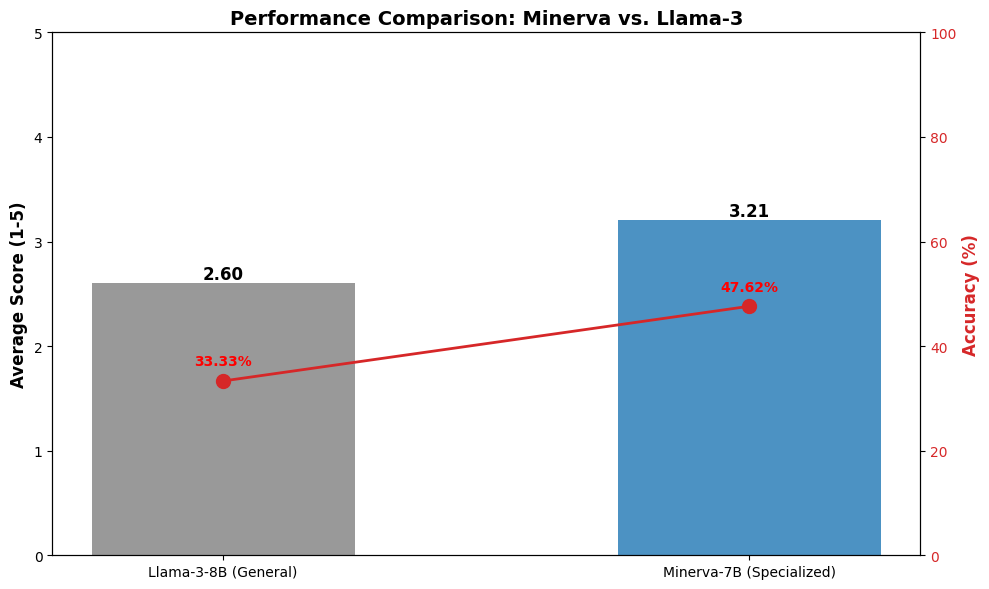

✅ نمودار ذخیره شد! فایل 'comparison_chart.png' را دانلود کن.


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# داده‌های نهایی
models = ['Llama-3-8B (General)', 'Minerva-7B (Specialized)']
scores = [2.60, 3.21]
accuracy = [33.33, 47.62]

# تنظیمات نمودار
fig, ax1 = plt.subplots(figsize=(10, 6))

# نمودار ستونی برای میانگین نمرات
color = 'tab:blue'
bars = ax1.bar(models, scores, color=['grey', '#1f77b4'], width=0.5, alpha=0.8)
ax1.set_ylabel('Average Score (1-5)', fontsize=12, fontweight='bold')
ax1.set_ylim(0, 5)
ax1.set_title('Performance Comparison: Minerva vs. Llama-3', fontsize=14, fontweight='bold')

# اضافه کردن عدد روی ستون‌ها
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

# اضافه کردن خط دقت (Accuracy)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.plot(models, accuracy, color=color, marker='o', linestyle='-', linewidth=2, markersize=10)
ax2.set_ylabel('Accuracy (%)', color=color, fontsize=12, fontweight='bold')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0, 100)

# اضافه کردن عدد روی نقاط نمودار خطی
for i, txt in enumerate(accuracy):
    ax2.text(i, txt + 3, f'{txt:.2f}%', color='red', ha='center', fontweight='bold')

# ذخیره نمودار
plt.tight_layout()
plt.savefig('comparison_chart.png', dpi=300)
plt.show()

print("✅ نمودار ذخیره شد! فایل 'comparison_chart.png' را دانلود کن.")

Optimization

---


Prompt Engineering


---







**FEW-SHOT EXPERIMENT - MINERVA**

In [1]:
!pip install -q gradio openai-whisper transformers accelerate bitsandbytes gtts langchain langchain-community langchain-core huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.2/803.2 kB 18.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.


In [2]:
import json
import re
import torch
import gc
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline, BitsAndBytesConfig

# ==========================================
# 0. MEMORY CLEANUP
# ==========================================
gc.collect()
torch.cuda.empty_cache()
print("🧹 GPU Memory Cleared!")

# ==========================================
# 1. DEFINING RAW DATA (چون ریست کردی باید دوباره تعریف بشه)
# ==========================================
RAW_TEXT_1 = """
---------------------------------------------------------Domanda 1----------------------------------------------------------------------------------------------
Quale di queste due frasi è grammaticalmente corretta?
a. Il papà è entusiato.
b. Il papà è entusiasta.
"b. Il papà è entusiasta."
---------------------------------------------------------Domanda 2----------------------------------------------------------------------------------------------
Quale di queste due frasi è grammaticalmente corretta?
a. Marco e Lucia sono molto belle.
b. Marco e Lucia sono molto belli.
"b. Marco e Lucia sono molto belli."
---------------------------------------------------------Domanda 3----------------------------------------------------------------------------------------------
Quale di queste due frasi è grammaticalmente corretta?
a. Il cane e il bambino correvano insieme.
b. Il cane e il bambino correva insieme.
"a. Il cane e il bambino correvano insieme."
---------------------------------------------------------Domanda 4----------------------------------------------------------------------------------------------
Quale di queste due frasi è grammaticalmente corretta?
a. Non so se al suo posto avrei fatto lo stesso.
b. Non so se al suo posto avessi fatto lo stesso.
"b. Non so se al suo posto avrei fatto lo stesso."
---------------------------------------------------------Domanda 5----------------------------------------------------------------------------------------------
Quale di queste due frasi è grammaticalmente corretta?
a. Quelli sono i libri della quale ti ho parlato.
b. Quelli sono i libri di cui ti ho parlato.
"b. Quelli sono i libri di cui ti ho parlato."
---------------------------------------------------------Domanda 6----------------------------------------------------------------------------------------------
Quale di queste due frasi è grammaticalmente corretta?
a. Ho incontrato Anna e gli ho dato un passaggio a casa.
b. Ho incontrato Anna e le ho dato un passaggio a casa.
"b. Ho incontrato Anna e le ho dato un passaggio a casa."
---------------------------------------------------------Domanda 7----------------------------------------------------------------------------------------------
Quale di queste due frasi è grammaticalmente corretta?
a. Ieri sono andato al cinema con mia madre.
b. Ieri ho andato al cinema con mia madre.
"La frase corretta è ""Ieri sono andato al cinema con mia madre."
---------------------------------------------------------Domanda 8----------------------------------------------------------------------------------------------
Quale di queste due frasi è grammaticalmente corretta?
a.  Il film che ho visto ieri mi è piaciuto molto.
b.  Il film il quale ho visto ieri mi è piaciuto molto.
"La frase corretta è: a. Il film che ho visto ieri mi è piaciuto molto.""
---------------------------------------------------------Domanda 9----------------------------------------------------------------------------------------------
Quale di queste due frasi è grammaticalmente corretta?
a. Quando Lucia e Marco arrivano, inizieremo a mangiare.
b. Quando Lucia e Marco arriva, inizieremo a mangiare."
"b. Quando Lucia e Marco arriva, inizieremo a mangiare."
---------------------------------------------------------Domanda 10----------------------------------------------------------------------------------------------
Quale di queste due frasi è grammaticalmente corretta?
a. Ieri sono andata al ristorante di cui mi hai parlato.
b. Ieri sono andata al ristorante che mi hai parlato.
"La frase corretta è la prima, ""Ieri sono andata al ristorante di cui mi hai parlato"
---------------------------------------------------------Domanda 11----------------------------------------------------------------------------------------------
Quale di queste due frasi è grammaticalmente corretta?
a. Sabato scorso di siamo divertito molto alla festa di Luca.
b. Sabato scorso di siamo divertiti molto alla festa di Luca.
"b. Sabato scorso ci siamo divertiti molto alla festa di Luca."
---------------------------------------------------------Domanda 12----------------------------------------------------------------------------------------------
1"Quale di queste due frasi è grammaticalmente corretta?
a. Spento la sveglia, mi sono alzata dal letto.
b. Spenta la sveglia, mi sono alzata dal letto."
"b. Spenta la sveglia, mi sono alzata dal letto."
---------------------------------------------------------Domanda 13----------------------------------------------------------------------------------------------
13,Quale di queste due frasi è grammaticalmente corretta?
a. Il sole splendeva gialla nel cielo.
b. Il sole splendeva giallo nel cielo.
"La risposta corretta è b. Il sole splendeva giallo nel cielo."
---------------------------------------------------------Domanda 14----------------------------------------------------------------------------------------------
Quale di queste due frasi è grammaticalmente corretta?
a. Ad Antonella le piacciono i film d'azione.
b. Ad Antonella piacciono i film d'azione.
"b. Ad Antonella piacciono i film d'azione."
---------------------------------------------------------Domanda 15----------------------------------------------------------------------------------------------
Quale di queste due frasi è grammaticalmente corretta?
a. Filippo si ha fatto male giocando a calcetto.
b. Filippo si è fatto male giocando a calcetto.
"b. Filippo si è fatto male giocando a calcetto."
---------------------------------------------------------Domanda 16----------------------------------------------------------------------------------------------
Quale di queste due frasi è grammaticalmente corretta?
a. Se volevo andare via l'avrei già fatto.
b. Se avessi voluto andare via l'avrei già fatto.
"b. Se avessi voluto andare via l'avrei già fatto."
---------------------------------------------------------Domanda 17----------------------------------------------------------------------------------------------
Quale di queste due frasi è grammaticalmente corretta?
a. Matteo, dopo aver salutato Luca, sono andati via.
b. Matteo, dopo aver salutato Luca, è andato via."
"b. Matteo, dopo aver salutato Luca, è andato via."
---------------------------------------------------------Domanda 18----------------------------------------------------------------------------------------------
Quale di queste due frasi è grammaticalmente corretta?
a. Ho letto il libro che mi hai consigliato.
b. Ho letto il libro di cui mi hai consigliato.
La frase corretta è: ""Ho letto il libro che mi hai consigliato."
---------------------------------------------------------Domanda 19----------------------------------------------------------------------------------------------
Quale di queste due frasi è grammaticalmente corretta?
a. Nella valle si sentiva un eco fortissimo.
b. Nella valle si sentiva un'eco fortissima.
"La frase corretta è la prima, "Nella valle si sentiva un eco fortissimo"
---------------------------------------------------------Domanda 20----------------------------------------------------------------------------------------------
Quale di queste due frasi è grammaticalmente corretta?
a. Il bambino ha rotto i giocattoli.
b. Il bambino ha rotti i giocattoli.
"b. Il bambino ha rotti i giocattoli."
"""

RAW_TEXT_2 = """
---------------------------------------------------------Domanda 1----------------------------------------------------------------------------------------------
Individua il soggetto nella frase seguente: Mi piace il gelato al cioccolato.
"Il soggetto è ""Mi piace"".
---------------------------------------------------------Domanda 2----------------------------------------------------------------------------------------------
Individua il soggetto nella frase seguente: Il gatto ha mangiato il topo.
"Il gatto è il soggetto della frase."
---------------------------------------------------------Domanda 3----------------------------------------------------------------------------------------------
Individua il soggetto nella frase seguente: Ieri ha piovuto tutta la giornata.
"Il soggetto è ""Ieri"".
---------------------------------------------------------Domanda 4----------------------------------------------------------------------------------------------
Individua il soggetto nella frase seguente: Anna si è fatta male cadendo dall'altalena.
"Il soggetto è ""Anna"".
---------------------------------------------------------Domanda 5----------------------------------------------------------------------------------------------
Individua il soggetto nella frase seguente: Chi ti ha detto di aprire la porta?
"Il soggetto è ""tu"" perché si riferisce alla persona che viene interrogata sulla questione.""
---------------------------------------------------------Domanda 6----------------------------------------------------------------------------------------------
Individua il soggetto nella frase seguente: A dirmelo è stato Luca.
"Luca."
---------------------------------------------------------Domanda 7----------------------------------------------------------------------------------------------
Individua il soggetto nella frase seguente: Oggi si mangia a casa
"Il soggetto è ""Oggi"" perché è la persona o l'oggetto che compie l'azione della frase.""
---------------------------------------------------------Domanda 8----------------------------------------------------------------------------------------------
Individua il soggetto della frase Solitamente mi lavo i capelli tre volte a settimana
"Il soggetto è ""mi"" (io).
---------------------------------------------------------Domanda 9----------------------------------------------------------------------------------------------
Individua il soggetto della frase: Chissà cosa è successo dopo
Il soggetto è ""cosa"".
---------------------------------------------------------Domanda 10----------------------------------------------------------------------------------------------
Individua il soggetto nella frase seguente: Ieri mi è capitata una cosa strana
"Il soggetto della frase è ""io"" perché la frase indica che l'azione viene compiuta da un individuo specifico, ovvero colui che parla o scrive.""
---------------------------------------------------------Domanda 11----------------------------------------------------------------------------------------------
"Indica quale funziona ha il ""che"" nella frase seguente: Che mi racconti di nuovo?"
"Il che è una congiunzione subordinante, quindi la risposta corretta è che funziona come subordinata alla frase principale ""mi racconti""."
---------------------------------------------------------Domanda 12----------------------------------------------------------------------------------------------
"Indica quale funziona ha il ""che"" nella frase seguente: Ieri ho incontrato Luca che mi ha raccontato del suo viaggio a Parigi."
"Il ""che"" nella frase è un pronome relativo che introduce una proposizione subordinata relativa al soggetto ""Luca"".
---------------------------------------------------------Domanda 13----------------------------------------------------------------------------------------------
"Indica quale funziona ha il ""che"" nella frase seguente: Stasera non posso fare troppo tardi che domani mi devo svegliare presto."
"Il ""che"" introduce una proposizione relativa (che specifica un termine della frase precedente) e quindi ha funzione di congiunzione subordinante.
---------------------------------------------------------Domanda 14----------------------------------------------------------------------------------------------
"Indica quale funziona ha il ""che"" nella frase seguente: Se non fossi riuscita a prendere l'ultimo treno non avrei saputo che fare."
"Il ""che"" introduce una proposizione relativa, quindi è la risposta corretta."
---------------------------------------------------------Domanda 15----------------------------------------------------------------------------------------------
"Indica quale funziona ha il ""che"" nella frase seguente: Che hai combinato!"
"Il che è una congiunzione subordinante che introduce una proposizione subordinata relativa, indicando un'azione o una situazione che si verifica dopo l'avverbio di tempo ""hai"".
---------------------------------------------------------Domanda 16----------------------------------------------------------------------------------------------
"Indica quale funziona ha il ""che"" nella frase seguente: Mi dispiace che te vada così presto."
"Il ""che"" in questa frase è una congiunzione subordinante che introduce la proposizione relativa ""Mi dispiace che"". Quindi, il ""che"" funziona come subordinata alla proposizione principale ""Mi dispiace che te vada così presto"".
---------------------------------------------------------Domanda 17----------------------------------------------------------------------------------------------
"Indica quale funziona ha il ""che"" nella frase seguente: Hai visto che bel giardino!"
"Il ""che"" è un pronome relativo"
---------------------------------------------------------Domanda 18----------------------------------------------------------------------------------------------
"Indica quale funziona ha il ""che"" nella frase seguente: Che hai fatto sabato sera?"
"Il ""che"" è una congiunzione subordinante che introduce la proposizione dipendente ""hai fatto sabato sera"". Quindi, la risposta è: ""Che hai fatto sabato sera?""
---------------------------------------------------------Domanda 19----------------------------------------------------------------------------------------------
"Indica quale funziona ha il ""che"" nella frase seguente: I film d'azione sono quelli che preferisco."
"Il ""che"" introduce una proposizione relativa, quindi la risposta è ""I film d'azione sono quelli che preferisco"".
---------------------------------------------------------Domanda 20----------------------------------------------------------------------------------------------
1"Indica quale funziona ha il ""che"" nella frase seguente: Ieri ho conosciuto Anna. Che persona interessante!"
"Il ""che"" in questa frase è un pronome relativo che introduce una subordinata relativa, ovvero la frase ""persona interessante"". Quindi il ""che"" funziona come congiunzione subordinante."
---------------------------------------------------------Domanda 21----------------------------------------------------------------------------------------------
1"Indica quale funziona ha il ""che"" nella frase seguente: Che film hai visto quanto sei andato al cinema?"
"Il ""che"" è una congiunzione che introduce una proposizione subordinata, quindi la risposta è ""hai visto""."
---------------------------------------------------------Domanda 22----------------------------------------------------------------------------------------------
"Indica quale funziona ha il ""che"" nella frase seguente: Avevo così tanto sonno che mi sono addormentato sul divano."
"Il ""che"" è una congiunzione coordinante."
"""

def parse_dataset(text_data, q_type="type1"):
    questions = []
    chunks = re.split(r'-{10,}Domanda \d+-{10,}', text_data)
    for chunk in chunks:
        chunk = chunk.strip()
        if not chunk: continue
        lines = [l.strip() for l in chunk.split('\n') if l.strip()]
        if q_type == "type1":
            answer_line = next((l for l in lines if l.startswith('"') or l.startswith("La frase") or l.startswith("b.") or l.startswith("a.")), lines[-1])
            question_text = "\n".join([l for l in lines if l != answer_line])
            ground_truth = answer_line.replace('"', '').strip()
        else:
            question_text = lines[0]
            if len(lines) > 1:
                ground_truth = " ".join(lines[1:]).replace('"', '').strip()
            else:
                ground_truth = "N/A"
        questions.append({"question": question_text, "ground_truth": ground_truth})
    return questions

# ساخت دیتاست
dataset = parse_dataset(RAW_TEXT_1, "type1") + parse_dataset(RAW_TEXT_2, "type2")
print(f"✅ Dataset Restored: {len(dataset)} items ready.")


# ==========================================
# 2. GENERATE ANSWERS (OPTIMIZED WITH PADDING)
# ==========================================
if len(dataset) > 0:
    MODEL_ID = "sapienzanlp/Minerva-7B-instruct-v1.0"
    print(f"⏳ Loading Minerva Model ({MODEL_ID})...")

    quant_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_compute_dtype=torch.float16
    )

    # توکنایزر با تنظیمات درست (Padding Side = Left)
    tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
    tokenizer.padding_side = "left"
    tokenizer.pad_token = tokenizer.eos_token

    model = AutoModelForCausalLM.from_pretrained(
        MODEL_ID,
        quantization_config=quant_config,
        device_map="auto"
    )

    pipe = pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
        max_new_tokens=150,
        temperature=0.1,
        do_sample=False,
        pad_token_id=tokenizer.eos_token_id
    )

    FEW_SHOT_PROMPT = """Sei un esperto di grammatica italiana. Rispondi alle domande seguendo gli esempi.

Esempio 1:
Domanda: Quale frase è corretta? a. Ciao b. Chau
Risposta: a. Ciao

Esempio 2:
Domanda: Individua il soggetto: 'Luca mangia la pizza'.
Risposta: Il soggetto è Luca.

Esempio 3:
Domanda: Trova l'errore: 'Ieri sono andato a il mare'.
Risposta: L'errore è 'a il', la forma corretta è 'al mare'.

Adesso tocca a te:
Domanda: {question}
Risposta:"""

    print("🚀 Starting Minerva Few-Shot generation (Fast Mode)...")
    final_data = []

    # آماده‌سازی پرامپت‌ها
    all_prompts = [FEW_SHOT_PROMPT.format(question=item['question']) for item in dataset]

    # اجرا با بچ سایز ۸
    results = pipe(all_prompts, batch_size=8)

    # استخراج جواب‌ها
    for i, (item, result) in enumerate(zip(dataset, results)):
        try:
            res = result[0]['generated_text']
            if "Adesso tocca a te:" in res:
                ans_part = res.split("Adesso tocca a te:")[-1]
                if "Risposta:" in ans_part:
                    clean_ans = ans_part.split("Risposta:")[-1].strip()
                else:
                    clean_ans = ans_part.strip()
            else:
                clean_ans = res
        except Exception as e:
            clean_ans = "Error"
            print(f"Error on {i}: {e}")

        final_data.append({
            "id": i+1,
            "question": item['question'],
            "ground_truth": item['ground_truth'],
            "answer_minerva": clean_ans
        })

    # ذخیره
    with open("minerva_fewshot.jsonl", "w", encoding="utf-8") as f:
        for entry in final_data:
            f.write(json.dumps(entry, ensure_ascii=False) + "\n")

    print("✅ Minerva Few-Shot Done! Saved to 'minerva_fewshot.jsonl'.")
    print("👉 ACTION: Restart Runtime (Restart session) and move to Llama.")
else:
    print("❌ Dataset is empty. Something went wrong with parsing.")

🧹 GPU Memory Cleared!
✅ Dataset Restored: 42 items ready.
⏳ Loading Minerva Model (sapienzanlp/Minerva-7B-instruct-v1.0)...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/670 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/761 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/226 [00:00<?, ?B/s]

Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🚀 Starting Minerva Few-Shot generation (Fast Mode)...
✅ Minerva Few-Shot Done! Saved to 'minerva_fewshot.jsonl'.
👉 ACTION: Restart Runtime (Restart session) and move to Llama.


GENERATE ANSWERS WITH LLAMA 3 (FEW-SHOT & BATCH)

In [1]:
import json
import re
import torch
import gc
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline, BitsAndBytesConfig

# ==========================================
# 0. MEMORY CLEANUP
# ==========================================
gc.collect()
torch.cuda.empty_cache()
print("🧹 GPU Memory Cleared!")

# ==========================================
# 1. RE-CREATE DATASET
# ==========================================
RAW_TEXT_1 = """
---------------------------------------------------------Domanda 1----------------------------------------------------------------------------------------------
Quale di queste due frasi è grammaticalmente corretta?
a. Il papà è entusiato.
b. Il papà è entusiasta.
"b. Il papà è entusiasta."
---------------------------------------------------------Domanda 2----------------------------------------------------------------------------------------------
Quale di queste due frasi è grammaticalmente corretta?
a. Marco e Lucia sono molto belle.
b. Marco e Lucia sono molto belli.
"b. Marco e Lucia sono molto belli."
---------------------------------------------------------Domanda 3----------------------------------------------------------------------------------------------
Quale di queste due frasi è grammaticalmente corretta?
a. Il cane e il bambino correvano insieme.
b. Il cane e il bambino correva insieme.
"a. Il cane e il bambino correvano insieme."
---------------------------------------------------------Domanda 4----------------------------------------------------------------------------------------------
Quale di queste due frasi è grammaticalmente corretta?
a. Non so se al suo posto avrei fatto lo stesso.
b. Non so se al suo posto avessi fatto lo stesso.
"b. Non so se al suo posto avrei fatto lo stesso."
---------------------------------------------------------Domanda 5----------------------------------------------------------------------------------------------
Quale di queste due frasi è grammaticalmente corretta?
a. Quelli sono i libri della quale ti ho parlato.
b. Quelli sono i libri di cui ti ho parlato.
"b. Quelli sono i libri di cui ti ho parlato."
---------------------------------------------------------Domanda 6----------------------------------------------------------------------------------------------
Quale di queste due frasi è grammaticalmente corretta?
a. Ho incontrato Anna e gli ho dato un passaggio a casa.
b. Ho incontrato Anna e le ho dato un passaggio a casa.
"b. Ho incontrato Anna e le ho dato un passaggio a casa."
---------------------------------------------------------Domanda 7----------------------------------------------------------------------------------------------
Quale di queste due frasi è grammaticalmente corretta?
a. Ieri sono andato al cinema con mia madre.
b. Ieri ho andato al cinema con mia madre.
"La frase corretta è ""Ieri sono andato al cinema con mia madre."
---------------------------------------------------------Domanda 8----------------------------------------------------------------------------------------------
Quale di queste due frasi è grammaticalmente corretta?
a.  Il film che ho visto ieri mi è piaciuto molto.
b.  Il film il quale ho visto ieri mi è piaciuto molto.
"La frase corretta è: a. Il film che ho visto ieri mi è piaciuto molto.""
---------------------------------------------------------Domanda 9----------------------------------------------------------------------------------------------
Quale di queste due frasi è grammaticalmente corretta?
a. Quando Lucia e Marco arrivano, inizieremo a mangiare.
b. Quando Lucia e Marco arriva, inizieremo a mangiare."
"b. Quando Lucia e Marco arriva, inizieremo a mangiare."
---------------------------------------------------------Domanda 10----------------------------------------------------------------------------------------------
Quale di queste due frasi è grammaticalmente corretta?
a. Ieri sono andata al ristorante di cui mi hai parlato.
b. Ieri sono andata al ristorante che mi hai parlato.
"La frase corretta è la prima, ""Ieri sono andata al ristorante di cui mi hai parlato"
---------------------------------------------------------Domanda 11----------------------------------------------------------------------------------------------
Quale di queste due frasi è grammaticalmente corretta?
a. Sabato scorso di siamo divertito molto alla festa di Luca.
b. Sabato scorso di siamo divertiti molto alla festa di Luca.
"b. Sabato scorso ci siamo divertiti molto alla festa di Luca."
---------------------------------------------------------Domanda 12----------------------------------------------------------------------------------------------
1"Quale di queste due frasi è grammaticalmente corretta?
a. Spento la sveglia, mi sono alzata dal letto.
b. Spenta la sveglia, mi sono alzata dal letto."
"b. Spenta la sveglia, mi sono alzata dal letto."
---------------------------------------------------------Domanda 13----------------------------------------------------------------------------------------------
13,Quale di queste due frasi è grammaticalmente corretta?
a. Il sole splendeva gialla nel cielo.
b. Il sole splendeva giallo nel cielo.
"La risposta corretta è b. Il sole splendeva giallo nel cielo."
---------------------------------------------------------Domanda 14----------------------------------------------------------------------------------------------
Quale di queste due frasi è grammaticalmente corretta?
a. Ad Antonella le piacciono i film d'azione.
b. Ad Antonella piacciono i film d'azione.
"b. Ad Antonella piacciono i film d'azione."
---------------------------------------------------------Domanda 15----------------------------------------------------------------------------------------------
Quale di queste due frasi è grammaticalmente corretta?
a. Filippo si ha fatto male giocando a calcetto.
b. Filippo si è fatto male giocando a calcetto.
"b. Filippo si è fatto male giocando a calcetto."
---------------------------------------------------------Domanda 16----------------------------------------------------------------------------------------------
Quale di queste due frasi è grammaticalmente corretta?
a. Se volevo andare via l'avrei già fatto.
b. Se avessi voluto andare via l'avrei già fatto.
"b. Se avessi voluto andare via l'avrei già fatto."
---------------------------------------------------------Domanda 17----------------------------------------------------------------------------------------------
Quale di queste due frasi è grammaticalmente corretta?
a. Matteo, dopo aver salutato Luca, sono andati via.
b. Matteo, dopo aver salutato Luca, è andato via."
"b. Matteo, dopo aver salutato Luca, è andato via."
---------------------------------------------------------Domanda 18----------------------------------------------------------------------------------------------
Quale di queste due frasi è grammaticalmente corretta?
a. Ho letto il libro che mi hai consigliato.
b. Ho letto il libro di cui mi hai consigliato.
La frase corretta è: ""Ho letto il libro che mi hai consigliato."
---------------------------------------------------------Domanda 19----------------------------------------------------------------------------------------------
Quale di queste due frasi è grammaticalmente corretta?
a. Nella valle si sentiva un eco fortissimo.
b. Nella valle si sentiva un'eco fortissima.
"La frase corretta è la prima, "Nella valle si sentiva un eco fortissimo"
---------------------------------------------------------Domanda 20----------------------------------------------------------------------------------------------
Quale di queste due frasi è grammaticalmente corretta?
a. Il bambino ha rotto i giocattoli.
b. Il bambino ha rotti i giocattoli.
"b. Il bambino ha rotti i giocattoli."
"""

RAW_TEXT_2 = """
---------------------------------------------------------Domanda 1----------------------------------------------------------------------------------------------
Individua il soggetto nella frase seguente: Mi piace il gelato al cioccolato.
"Il soggetto è ""Mi piace"".
---------------------------------------------------------Domanda 2----------------------------------------------------------------------------------------------
Individua il soggetto nella frase seguente: Il gatto ha mangiato il topo.
"Il gatto è il soggetto della frase."
---------------------------------------------------------Domanda 3----------------------------------------------------------------------------------------------
Individua il soggetto nella frase seguente: Ieri ha piovuto tutta la giornata.
"Il soggetto è ""Ieri"".
---------------------------------------------------------Domanda 4----------------------------------------------------------------------------------------------
Individua il soggetto nella frase seguente: Anna si è fatta male cadendo dall'altalena.
"Il soggetto è ""Anna"".
---------------------------------------------------------Domanda 5----------------------------------------------------------------------------------------------
Individua il soggetto nella frase seguente: Chi ti ha detto di aprire la porta?
"Il soggetto è ""tu"" perché si riferisce alla persona che viene interrogata sulla questione.""
---------------------------------------------------------Domanda 6----------------------------------------------------------------------------------------------
Individua il soggetto nella frase seguente: A dirmelo è stato Luca.
"Luca."
---------------------------------------------------------Domanda 7----------------------------------------------------------------------------------------------
Individua il soggetto nella frase seguente: Oggi si mangia a casa
"Il soggetto è ""Oggi"" perché è la persona o l'oggetto che compie l'azione della frase.""
---------------------------------------------------------Domanda 8----------------------------------------------------------------------------------------------
Individua il soggetto della frase Solitamente mi lavo i capelli tre volte a settimana
"Il soggetto è ""mi"" (io).
---------------------------------------------------------Domanda 9----------------------------------------------------------------------------------------------
Individua il soggetto della frase: Chissà cosa è successo dopo
Il soggetto è ""cosa"".
---------------------------------------------------------Domanda 10----------------------------------------------------------------------------------------------
Individua il soggetto nella frase seguente: Ieri mi è capitata una cosa strana
"Il soggetto della frase è ""io"" perché la frase indica che l'azione viene compiuta da un individuo specifico, ovvero colui che parla o scrive.""
---------------------------------------------------------Domanda 11----------------------------------------------------------------------------------------------
"Indica quale funziona ha il ""che"" nella frase seguente: Che mi racconti di nuovo?"
"Il che è una congiunzione subordinante, quindi la risposta corretta è che funziona come subordinata alla frase principale ""mi racconti""."
---------------------------------------------------------Domanda 12----------------------------------------------------------------------------------------------
"Indica quale funziona ha il ""che"" nella frase seguente: Ieri ho incontrato Luca che mi ha raccontato del suo viaggio a Parigi."
"Il ""che"" nella frase è un pronome relativo che introduce una proposizione subordinata relativa al soggetto ""Luca"".
---------------------------------------------------------Domanda 13----------------------------------------------------------------------------------------------
"Indica quale funziona ha il ""che"" nella frase seguente: Stasera non posso fare troppo tardi che domani mi devo svegliare presto."
"Il ""che"" introduce una proposizione relativa (che specifica un termine della frase precedente) e quindi ha funzione di congiunzione subordinante.
---------------------------------------------------------Domanda 14----------------------------------------------------------------------------------------------
"Indica quale funziona ha il ""che"" nella frase seguente: Se non fossi riuscita a prendere l'ultimo treno non avrei saputo che fare."
"Il ""che"" introduce una proposizione relativa, quindi è la risposta corretta."
---------------------------------------------------------Domanda 15----------------------------------------------------------------------------------------------
"Indica quale funziona ha il ""che"" nella frase seguente: Che hai combinato!"
"Il che è una congiunzione subordinante che introduce una proposizione subordinata relativa, indicando un'azione o una situazione che si verifica dopo l'avverbio di tempo ""hai"".
---------------------------------------------------------Domanda 16----------------------------------------------------------------------------------------------
"Indica quale funziona ha il ""che"" nella frase seguente: Mi dispiace che te vada così presto."
"Il ""che"" in questa frase è una congiunzione subordinante che introduce la proposizione relativa ""Mi dispiace che"". Quindi, il ""che"" funziona come subordinata alla proposizione principale ""Mi dispiace che te vada così presto"".
---------------------------------------------------------Domanda 17----------------------------------------------------------------------------------------------
"Indica quale funziona ha il ""che"" nella frase seguente: Hai visto che bel giardino!"
"Il ""che"" è un pronome relativo"
---------------------------------------------------------Domanda 18----------------------------------------------------------------------------------------------
"Indica quale funziona ha il ""che"" nella frase seguente: Che hai fatto sabato sera?"
"Il ""che"" è una congiunzione subordinante che introduce la proposizione dipendente ""hai fatto sabato sera"". Quindi, la risposta è: ""Che hai fatto sabato sera?""
---------------------------------------------------------Domanda 19----------------------------------------------------------------------------------------------
"Indica quale funziona ha il ""che"" nella frase seguente: I film d'azione sono quelli che preferisco."
"Il ""che"" introduce una proposizione relativa, quindi la risposta è ""I film d'azione sono quelli che preferisco"".
---------------------------------------------------------Domanda 20----------------------------------------------------------------------------------------------
1"Indica quale funziona ha il ""che"" nella frase seguente: Ieri ho conosciuto Anna. Che persona interessante!"
"Il ""che"" in questa frase è un pronome relativo che introduce una subordinata relativa, ovvero la frase ""persona interessante"". Quindi il ""che"" funziona come congiunzione subordinante."
---------------------------------------------------------Domanda 21----------------------------------------------------------------------------------------------
1"Indica quale funziona ha il ""che"" nella frase seguente: Che film hai visto quanto sei andato al cinema?"
"Il ""che"" è una congiunzione che introduce una proposizione subordinata, quindi la risposta è ""hai visto""."
---------------------------------------------------------Domanda 22----------------------------------------------------------------------------------------------
"Indica quale funziona ha il ""che"" nella frase seguente: Avevo così tanto sonno che mi sono addormentato sul divano."
"Il ""che"" è una congiunzione coordinante."
"""

def parse_dataset(text_data, q_type="type1"):
    questions = []
    chunks = re.split(r'-{10,}Domanda \d+-{10,}', text_data)
    for chunk in chunks:
        chunk = chunk.strip()
        if not chunk: continue
        lines = [l.strip() for l in chunk.split('\n') if l.strip()]
        if q_type == "type1":
            answer_line = next((l for l in lines if l.startswith('"') or l.startswith("La frase") or l.startswith("b.") or l.startswith("a.")), lines[-1])
            question_text = "\n".join([l for l in lines if l != answer_line])
            ground_truth = answer_line.replace('"', '').strip()
        else:
            question_text = lines[0]
            if len(lines) > 1:
                ground_truth = " ".join(lines[1:]).replace('"', '').strip()
            else:
                ground_truth = "N/A"
        questions.append({"question": question_text, "ground_truth": ground_truth})
    return questions

dataset = parse_dataset(RAW_TEXT_1, "type1") + parse_dataset(RAW_TEXT_2, "type2")
print(f"✅ Dataset Restored: {len(dataset)} items ready.")


# ==========================================
# 2. GENERATE ANSWERS WITH LLAMA 3 (FEW-SHOT & BATCH)
# ==========================================
MODEL_ID = "unsloth/llama-3-8b-Instruct-bnb-4bit"
print(f"⏳ Loading {MODEL_ID} for Few-Shot...")

quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True
)

# تنظیمات توکنایزر برای پدینگ صحیح (مهم برای بچ پروسسینگ)
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    quantization_config=quant_config,
    device_map="auto"
)

pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=150,
    temperature=0.1,
    do_sample=False,
    pad_token_id=tokenizer.eos_token_id
)

# پرامپت انگلیسی برای Llama (با مثال)
FEW_SHOT_PROMPT_LLAMA = """You are an Italian Grammar Expert. Answer based on the examples.

Example 1:
Question: Quale frase è corretta? a. Ciao b. Chau
Answer: a. Ciao

Example 2:
Question: Individua il soggetto: 'Luca mangia la pizza'.
Answer: Il soggetto è Luca.

Your Turn:
Question: {question}
Answer:"""

print("🚀 Starting Llama-3 Few-Shot generation (Fast Mode)...")
final_data = []

# 1. آماده‌سازی پرامپت‌ها
all_prompts = [FEW_SHOT_PROMPT_LLAMA.format(question=item['question']) for item in dataset]

# 2. پردازش دسته‌ای
results = pipe(all_prompts, batch_size=8)

# 3. استخراج
for i, (item, result) in enumerate(zip(dataset, results)):
    try:
        res = result[0]['generated_text']
        # تمیزکاری
        if "Your Turn:" in res:
            ans_part = res.split("Your Turn:")[-1]
            if "Answer:" in ans_part:
                clean_ans = ans_part.split("Answer:")[-1].strip()
            else:
                clean_ans = ans_part.strip()
        else:
            clean_ans = res
    except Exception as e:
        clean_ans = "Error"

    final_data.append({
        "id": i+1,
        "question": item['question'],
        "ground_truth": item['ground_truth'],
        "answer_minerva": clean_ans # اسم کلید ثابت
    })

with open("llama_fewshot.jsonl", "w", encoding="utf-8") as f:
    for entry in final_data:
        f.write(json.dumps(entry, ensure_ascii=False) + "\n")

print("✅ Llama Few-Shot Done! Saved to 'llama_fewshot.jsonl'.")
print("👉 ACTION: Restart Runtime for the FINAL evaluation step!")

🧹 GPU Memory Cleared!
✅ Dataset Restored: 42 items ready.
⏳ Loading unsloth/llama-3-8b-Instruct-bnb-4bit for Few-Shot...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/quantizers/auto.py:239: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.
  warnings.warn(warning_msg)


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/220 [00:00<?, ?B/s]

Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🚀 Starting Llama-3 Few-Shot generation (Fast Mode)...
✅ Llama Few-Shot Done! Saved to 'llama_fewshot.jsonl'.
👉 ACTION: Restart Runtime for the FINAL evaluation step!


In [1]:
import os, json, csv
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline, BitsAndBytesConfig

# تنظیمات
JUDGE_MODEL = "Qwen/Qwen2.5-7B-Instruct"
FILES_TO_EVAL = [
    ("minerva_fewshot.jsonl", "minerva_fs_eval.csv"), # فایل ورودی -> فایل خروجی
    ("llama_fewshot.jsonl", "llama_fs_eval.csv")
]

# لود کردن داور
print(f"⚖️ Loading Judge: {JUDGE_MODEL}...")
quant_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=torch.float16)
tokenizer = AutoTokenizer.from_pretrained(JUDGE_MODEL, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(JUDGE_MODEL, quantization_config=quant_config, device_map="auto", trust_remote_code=True)
judge_pipe = pipeline("text-generation", model=model, tokenizer=tokenizer, max_new_tokens=250)

EVAL_PROMPT = """Sei un professore universitario. Confronta la risposta AI con la risposta corretta.

Domanda: {question}
Risposta Corretta: {reference}
Risposta AI: {candidate}

Assegna un punteggio da 1 a 5 basato sulla correttezza.
Rispondi SOLO in formato JSON: {{"score": <int>, "reasoning": "<breve testo>"}}
"""

for input_file, output_file in FILES_TO_EVAL:
    if not os.path.exists(input_file):
        print(f"⚠️ Error: {input_file} not found. Skipping.")
        continue

    print(f"📊 Evaluating {input_file}...")
    with open(input_file, 'r', encoding='utf-8') as f:
        rows = [json.loads(line) for line in f]

    results = []
    for row in rows:
        prompt_text = EVAL_PROMPT.format(
            question=row['question'],
            reference=row['ground_truth'],
            candidate=row['answer_minerva']
        )
        messages = [{"role": "user", "content": prompt_text}]
        formatted_prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

        try:
            out = judge_pipe(formatted_prompt, do_sample=False, temperature=0.1)[0]['generated_text']
            # استخراج JSON
            json_str = out.split(formatted_prompt)[-1].strip()
            if "```json" in json_str: json_str = json_str.split("```json")[1].split("```")[0].strip()
            elif "{" in json_str: json_str = json_str[json_str.find("{"):json_str.rfind("}")+1]

            data = json.loads(json_str)
            score = data.get("score", 1)
        except:
            score = 1 # اگر ارور داد، نمره ۱ بده

        results.append({"id": row['id'], "score": score})

    # ذخیره در CSV
    with open(output_file, 'w', newline='') as f:
        w = csv.DictWriter(f, fieldnames=["id", "score"])
        w.writeheader()
        w.writerows(results)
    print(f"✅ Finished! Saved to {output_file}")

print("\n🎉 Evaluation Complete!")

⚖️ Loading Judge: Qwen/Qwen2.5-7B-Instruct...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/3.95G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.56G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


📊 Evaluating minerva_fewshot.jsonl...


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


✅ Finished! Saved to minerva_fs_eval.csv
📊 Evaluating llama_fewshot.jsonl...
✅ Finished! Saved to llama_fs_eval.csv

🎉 Evaluation Complete!


📊 FINAL THESIS REPORT GENERATION
✅ Minerva (Zero-Shot): 47.62%
✅ Minerva (Few-Shot): 23.81%
✅ Llama-3 (Zero-Shot): 33.33%
✅ Llama-3 (Few-Shot): 38.10%


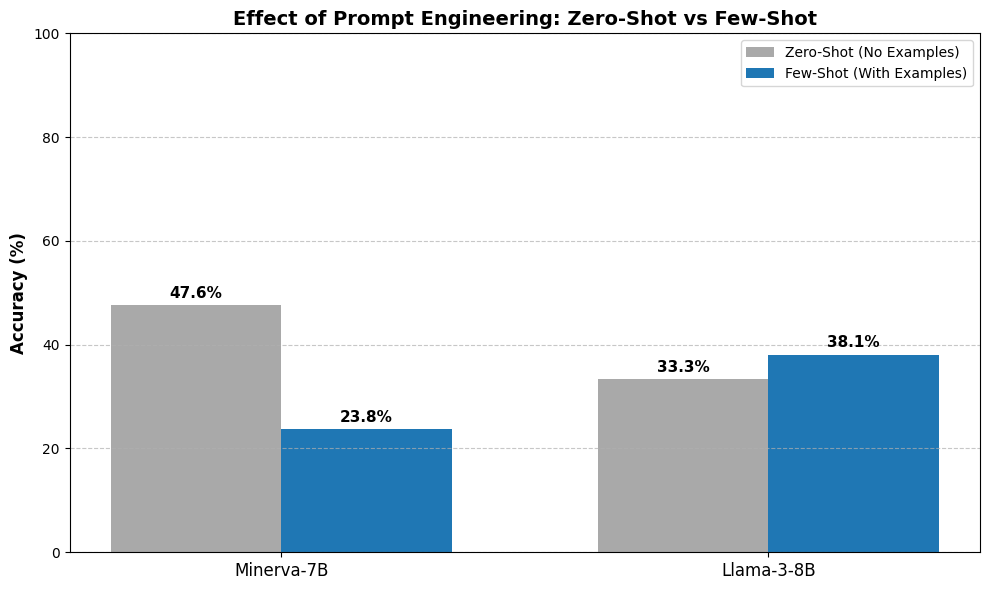


✅ Chart saved as 'final_thesis_chart.png'. DOWNLOAD IT NOW!


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

print("📊 FINAL THESIS REPORT GENERATION")
print("="*40)

# تعریف فایل‌ها
files = {
    "Minerva (Zero-Shot)": "thesis_evaluation_results.csv",
    "Minerva (Few-Shot)": "minerva_fs_eval.csv",
    "Llama-3 (Zero-Shot)": "llama_evaluation_results.csv",
    "Llama-3 (Few-Shot)": "llama_fs_eval.csv"
}

results = {}

# خواندن و محاسبه دقت
for name, filepath in files.items():
    if os.path.exists(filepath):
        try:
            df = pd.read_csv(filepath)
            # پیدا کردن ستون نمره (ممکن است score یا judge_score باشد)
            score_col = 'score' if 'score' in df.columns else 'judge_score'

            # محاسبه دقت (نمره ۴ و ۵ قبول است)
            accuracy = (df[score_col] >= 4).mean() * 100
            results[name] = accuracy
            print(f"✅ {name}: {accuracy:.2f}%")
        except Exception as e:
            print(f"❌ Error reading {name}: {e}")
            results[name] = 0
    else:
        print(f"⚠️ Missing file for {name} (Upload it to see results!)")
        results[name] = 0

print("="*40)

# --- رسم نمودار حرفه‌ای ---
models = ['Minerva-7B', 'Llama-3-8B']
zero_shot_scores = [results["Minerva (Zero-Shot)"], results["Llama-3 (Zero-Shot)"]]
few_shot_scores = [results["Minerva (Few-Shot)"], results["Llama-3 (Few-Shot)"]]

x = np.arange(len(models))  # موقعیت لیبل‌ها
width = 0.35  # عرض ستون‌ها

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, zero_shot_scores, width, label='Zero-Shot (No Examples)', color='#A9A9A9') # طوسی
rects2 = ax.bar(x + width/2, few_shot_scores, width, label='Few-Shot (With Examples)', color='#1f77b4') # آبی

# خوشگل‌سازی نمودار
ax.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax.set_title('Effect of Prompt Engineering: Zero-Shot vs Few-Shot', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=12)
ax.set_ylim(0, 100)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

# تابع نوشتن عدد روی ستون‌ها
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontweight='bold', fontsize=11)

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.savefig('final_thesis_chart.png', dpi=300)
plt.show()

print("\n✅ Chart saved as 'final_thesis_chart.png'. DOWNLOAD IT NOW!")